In [1]:
### First get data.

import numpy as np
from keras.utils.np_utils import to_categorical # Just for one-hots!
import random
import os

os.chdir(r"C:\Users\tedjt\Desktop\OIST\A313")
raw_text = open("wonderland.txt", 'r', encoding='utf-8').read()
raw_text = raw_text.lower().replace("\n", " ")

chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

n_chars, n_vocab = len(raw_text), len(chars)
seq_length = 50
data_x, data_y = [], []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    data_x.append([char_to_int[char] for char in seq_in])
    data_y.append(char_to_int[seq_out])
n_patterns = len(data_x)

x = np.reshape(data_x, (n_patterns, seq_length))
x = to_categorical(data_x)
y = to_categorical(data_y)

x_keep, y_keep = x, y

print("Length of Alice in Wonderland: \t{} characters.".format(n_chars))
print("Different characters: \t\t{} characters.".format(n_vocab))
print("There are {} sequences of {} characters in a row.".format(n_patterns, seq_length))

def train_test(xs, ys, train_percent = .85):
    index = [i for i in range(len(ys))]
    random.shuffle(index)
    train_index = index[:int(train_percent * len(index))]
    test_index = index[int(train_percent * len(index)):]
    
    x_train = xs[train_index]
    x_test = xs[test_index]
    y_train = ys[train_index]
    y_test = ys[test_index]
    
    return(x_train, x_test, y_train, y_test)
    
x_train, x_test, y_train, y_test = train_test(x, y)
print("\nTrain: \n\t Input: {0}, \t Output: {1}.".format(x_train.shape, y_train.shape))
print("\nTest: \n\t Input: {0}, \t Output: {1}.".format(x_test.shape, y_test.shape))

def get_batch(test = False, size = 64):
    if(test): x, y = x_test, y_test
    else:     x, y = x_train, y_train
    index = [i for i in range(len(y))]
    random.shuffle(index)
    index = index[:size]
    x, y = x[index], y[index]
    return(x, y)

Length of Alice in Wonderland: 	143426 characters.
Different characters: 		38 characters.
There are 143376 sequences of 50 characters in a row.

Train: 
	 Input: (121869, 50, 38), 	 Output: (121869, 38).

Test: 
	 Input: (21507, 50, 38), 	 Output: (21507, 38).


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Cheat(nn.Module):
    def __init__(self):
        super(Cheat, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(
                in_channels = n_vocab,
                out_channels = 64,
                kernel_size = 1),
            nn.LeakyReLU()
        )
        
        self.lstm = nn.LSTM(
                        input_size = 64,
                        hidden_size = 256, 
                        num_layers = 2,
                        batch_first = True, bias = True)
        
        self.lin = nn.Sequential(
            #nn.LeakyReLU(),
            nn.Linear(
                in_features = 256,
                out_features = n_vocab),
            #nn.Softmax()
        )
        
        self.to(device)
        
    def forward(self, x):
        if(type(x) == np.ndarray): x = torch.tensor(x).to(device)
        if(len(x.shape) == 2): x = x.unsqueeze(0)
        x = x.permute(0, 2, 1)
        x = self.cnn(x).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:,-1,:]
        x = self.lin(x)
        return(x)
    
cheat = Cheat()
opti = Adam(cheat.parameters())
print("\n{}\n\n\n{}\n".format(cheat, summary(cheat, (1, seq_length, n_vocab))))


Cheat(
  (cnn): Sequential(
    (0): Conv1d(38, 64, kernel_size=(1,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (lin): Sequential(
    (0): Linear(in_features=256, out_features=38, bias=True)
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
Cheat                                    --                        --
├─Sequential: 1-1                        [1, 64, 50]               --
│    └─Conv1d: 2-1                       [1, 64, 50]               2,496
│    └─LeakyReLU: 2-2                    [1, 64, 50]               --
├─LSTM: 1-2                              [1, 50, 256]              856,064
├─Sequential: 1-3                        [1, 38]                   --
│    └─Linear: 2-3                       [1, 38]                   9,766
Total params: 868,326
Trainable params: 868,326
Non-trainable params: 0
Total mult-adds (M): 42.94
Input size (MB): 0.01
Forward/backward pass size (M

In [3]:
def try_it(times = 1, length = 10):
    cheat.eval()
    index = [i for i in range(x_test.shape[0])]
    random.shuffle(index)
    index = index[:times]
    xs = x_test[index]
    
    for x in xs:
        x_ = np.argmax(x, 1)
        x_ = ''.join([int_to_char[x_[i]] for i in range(seq_length)])
        pred_list = []
        for i in range(length):
            pred = cheat(x).detach().cpu().numpy()
            pred_list.append(int_to_char[np.argmax(pred)])
            pred = np.expand_dims(to_categorical(char_to_int[pred_list[-1]], num_classes = n_vocab), axis = 0)
            x = np.vstack([x[1:], pred])
        print("\nGiven:\n\t'{}'\n\npredicted:\n\t'{}'".format(x_, x_ + " | " + "".join(pred_list)))
    
try_it()


Given:
	' out, you know.' he was looking up into the sky al'

predicted:
	' out, you know.' he was looking up into the sky al | xxxxxxxxxx'


In [4]:
def try_it_easier(length = 10):
    index = [i for i in range(x_keep.shape[0]-(length + seq_length))]
    random.shuffle(index)
    index = index[0]
    pred_list = []
    for i in range(length):
        seq_in = raw_text[index + i : index + i + seq_length]
        seq_in = [char_to_int[char] for char in seq_in]
        seq_in = to_categorical(seq_in, n_vocab)
        pred = cheat(seq_in).detach().cpu().numpy()
        pred_list.append(int_to_char[np.argmax(pred)])
    print("\nGiven:\n\t'{}'\n\npredicted:\n\t'{}'".format(
        raw_text[index : index + seq_length] + " | " + raw_text[index + seq_length : index + length + seq_length], 
        raw_text[index : index + seq_length] + " | " + "".join(pred_list)))

try_it_easier()


Given:
	'paper label, with the words 'drink me' beautifully |  printed o'

predicted:
	'paper label, with the words 'drink me' beautifully | xxxxxxxxxx'


In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
crit = nn.CrossEntropyLoss()

def train(epochs = 64, batch_size = 64):
    losses = []
    for e in tqdm(range(epochs)):
        cheat.train()
        x, y = get_batch(test = False, size = batch_size)
        pred = cheat(x)
        y = np.argmax(y, 1)
        loss = crit(pred, torch.tensor(y).to(device))
        opti.zero_grad()
        loss.backward()
        opti.step()
        losses.append(loss.item())
    plt.plot([i for i in range(len(losses))], losses)
    plt.show()

Training...


  0%|          | 0/512 [00:00<?, ?it/s]

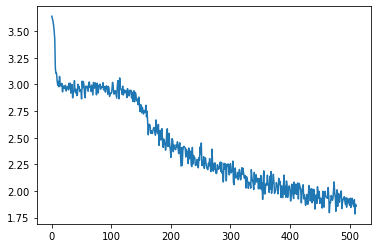

Let's try it!

Given:
	'ing at the mushroom (she had kept a piece of it in'

predicted:
	'ing at the mushroom (she had kept a piece of it in |  a look to the mooked and the mooked and the mooked and the mooked and the mooked and the mooked and'

Given:
	'o?' said one of the jurymen.  'it isn't directed a | t all,' said the white rabbit; 'in fact, there's nothing written on the outside.' he unfolded the pa'

predicted:
	'o?' said one of the jurymen.  'it isn't directed a | n all   said the daonh toteit  an  aoth  ahe   s aot eng aaonh r af the mnthened   a dldene d ahe do'
Training...


  0%|          | 0/512 [00:00<?, ?it/s]

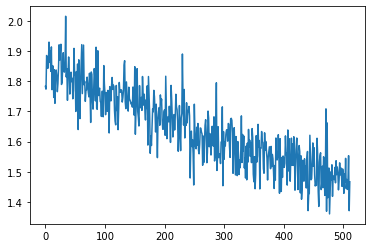

Let's try it!

Given:
	'll. soup does very well without--maybe it's always'

predicted:
	'll. soup does very well without--maybe it's always |  and was a little with a little with a little with a little with a little with a little with a littl'

Given:
	'peared, and then alice put down her flamingo, and  | began an account of the game, feeling very glad she had someone to listen to her. the cat seemed to '

predicted:
	'peared, and then alice put down her flamingo, and  | tegan t dankourt af the wrre  aorl ng aery doat noe wad neue n dth setten ah sers 'he sateshemed to '
Training...


  0%|          | 0/512 [00:00<?, ?it/s]

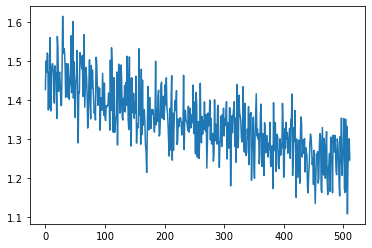

Let's try it!

Given:
	'large one, but the three were all crowded together'

predicted:
	'large one, but the three were all crowded together | , and the mock turtle so she was a little to alice, and the mock turtle so she was a little to alice'

Given:
	'right, so far,' said the king, and he went on mutt | ering over the verses to himself: '"we know it to be true--" that's the jury, of course--"i gave her'

predicted:
	'right, so far,' said the king, and he went on mutt | er ng ofer the teryertoo hes elf  'i-orwnow tt wh he aoaen-a  het s the mury  af tourse -a nmave ter'
Training...


  0%|          | 0/512 [00:00<?, ?it/s]

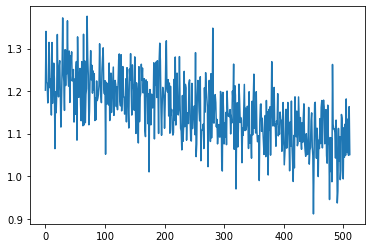

Let's try it!

Given:
	'nvented it just now.'  'it's the oldest rule in th'

predicted:
	'nvented it just now.'  'it's the oldest rule in th | e sea, and she went on about at the white rabbit was on the sea, and she was not at all the white ra'

Given:
	'ees, and i've tried banks, and i've tried hedges,' |  the pigeon went on, without attending to her; 'but those serpents! there's no pleasing them!'  alic'

predicted:
	'ees, and i've tried banks, and i've tried hedges,' |  the mageon iant on  'ithout a  end ng ao her  aiut iheue taepent  'the e s no uoaaseng ohe  ' s'lic'
Training...


  0%|          | 0/512 [00:00<?, ?it/s]

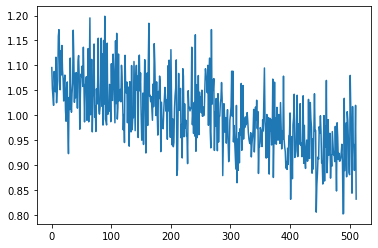

Let's try it!

Given:
	' said the dodo solemnly, rising to its feet, 'i mo'

predicted:
	' said the dodo solemnly, rising to its feet, 'i mo | ne it was the court of the court, and she was going to the door of the court, and she said to hersel'

Given:
	' sharp bark just over her head made her look up in |  a great hurry.  an enormous puppy was looking down at her with large round eyes, and feebly stretch'

predicted:
	' sharp bark just over her head made her look up in |  a lreat hurry   'ldexdumeuseolzpy aos gooking aown at ter heth targe feusd taes  and sellle ttoeach'
Training...


  0%|          | 0/512 [00:00<?, ?it/s]

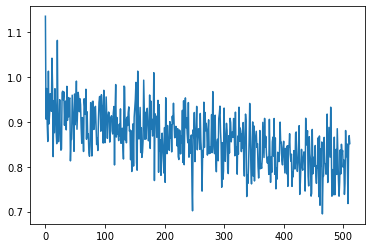

Let's try it!

Given:
	'r of it: 'no room! no room!' they cried out when t'

predicted:
	'r of it: 'no room! no room!' they cried out when t | he march hare interrupted in a minute, 'i don't know it is all the time they were like a story of th'

Given:
	'  (before she had this fit)    an obstacle that ca | me between     him, and ourselves, and it.     don't let him know she liked them best,     for this '

predicted:
	'  (before she had this fit)    an obstacle that ca | me oeaween t    om  and fnr  lves  and st      cen't le  mes hnow ihe ciked the ,aeht, a    or this '
Training...


  0%|          | 0/512 [00:00<?, ?it/s]

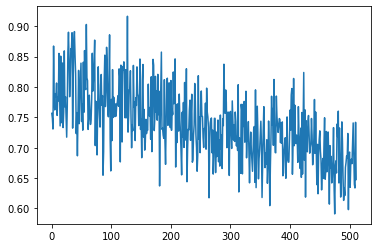

Let's try it!

Given:
	'so much contradicted in her life before, and she f'

predicted:
	'so much contradicted in her life before, and she f | ound that she had to be no use in saccosted on.  'not the same sid in the diract in the directions w'

Given:
	'top of its voice.  'back to land again, and that's |  all the first figure,' said the mock turtle, suddenly dropping his voice; and the two creatures, wh'

predicted:
	'top of its voice.  'back to land again, and that's |  mll the tirst tigure,' said the dock turtle. 'hpdenly drepping aes toice. and the mhi creatures  th'
Training...


  0%|          | 0/512 [00:00<?, ?it/s]

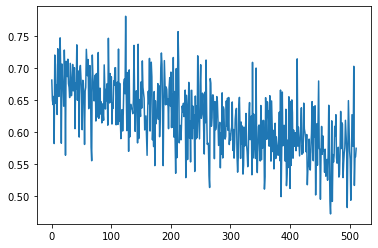

Let's try it!

Given:
	' a little larger, sir, if you wouldn't mind,' said'

predicted:
	' a little larger, sir, if you wouldn't mind,' said |  alice, 'and what a could way of extrark of much, i don't know what to say to this, so she went on, '

Given:
	', rather timidly, as she did not at all know wheth | er it would like the name: however, it only grinned a little wider. 'come, it's pleased so far,' tho'

predicted:
	', rather timidly, as she did not at all know wheth | er it wauld bike the ceme  aowever, it wnly goinned anlittle woter.  wome, tt's aleased so far   tho'
Training...


  0%|          | 0/512 [00:00<?, ?it/s]

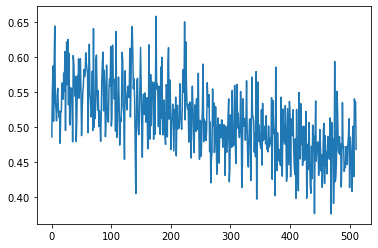

Let's try it!

Given:
	'thing about the games now.'     chapter x. the lob'

predicted:
	'thing about the games now.'     chapter x. the lob | sters all the rest of the end of the trial any the shore, and then a rabbit with the treaself on in '

Given:
	'so its eyes were getting extremely small for a bab | y: altogether alice did not like the look of the thing at all. 'but perhaps it was only sobbing,' sh'

predicted:
	'so its eyes were getting extremely small for a bab | y: antogether alice did not like the book of the treng a  all. 'bet ierhaps it was only aobbing!' sa'
Training...


  0%|          | 0/512 [00:00<?, ?it/s]

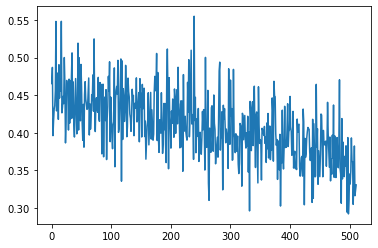

Let's try it!

Given:
	' course it was,' said the mock turtle.  'and how d'

predicted:
	' course it was,' said the mock turtle.  'and how d | o you mean that you that down, but she did not getting out of the wood--'she oug the reason it in a '

Given:
	'however, the moment they saw her, they hurried bac | k to the game, the queen merely remarking that a moment's delay would cost them their lives.  all th'

predicted:
	'however, the moment they saw her, they hurried bac | k to the came, the pueen iersly remarking toet a momentis tollr would hont them their loves.  'll th'


In [6]:
for i in range(10):
    print("Training...")
    train(epochs = 512, batch_size = 512)
    print("Let's try it!")
    try_it(times = 1, length = 100)
    try_it_easier(length = 100)